# Plant Identification for Weed Control Project

## Libraries

In [1]:
import sys
import kagglehub
import warnings
from pathlib import Path
import tifffile as tiff
import matplotlib.pyplot as plt
import random
import pandas as pd
import numpy as np
import seaborn as sns
import os
import piexif
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.utils.class_weight import compute_class_weight
from PIL import Image
from pathlib import Path
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

## Load Data

In [2]:
!{sys.executable} -m pip install kagglehub tifffile

In [3]:
warnings.filterwarnings("ignore", category=UserWarning)

# Download dataset locally
path = kagglehub.dataset_download("fpeccia/weed-detection-in-soybean-crops")
print("Path:", path)

Path: C:\Users\16302\.cache\kagglehub\datasets\fpeccia\weed-detection-in-soybean-crops\versions\1


## Data Preparation and Exploratory Data Analysis

           image_count
class                 
broadleaf         1191
grass             3520
soil              3249
soybean           7376


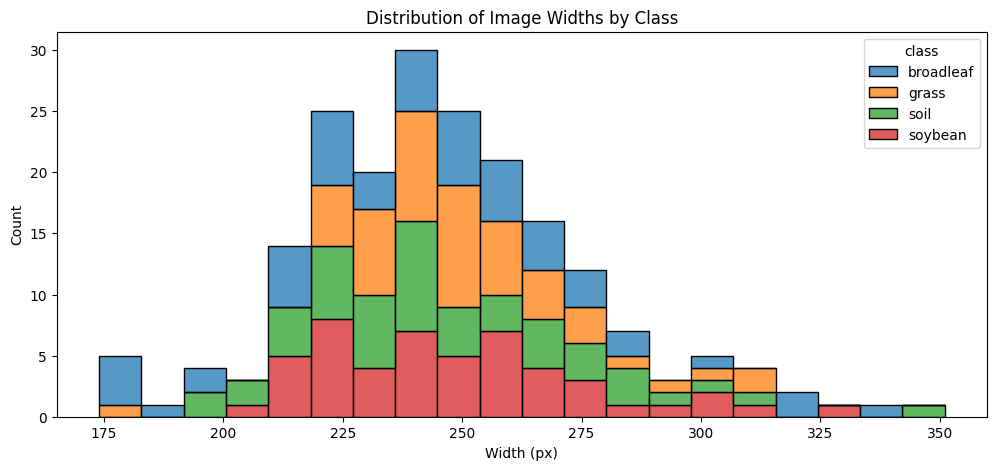

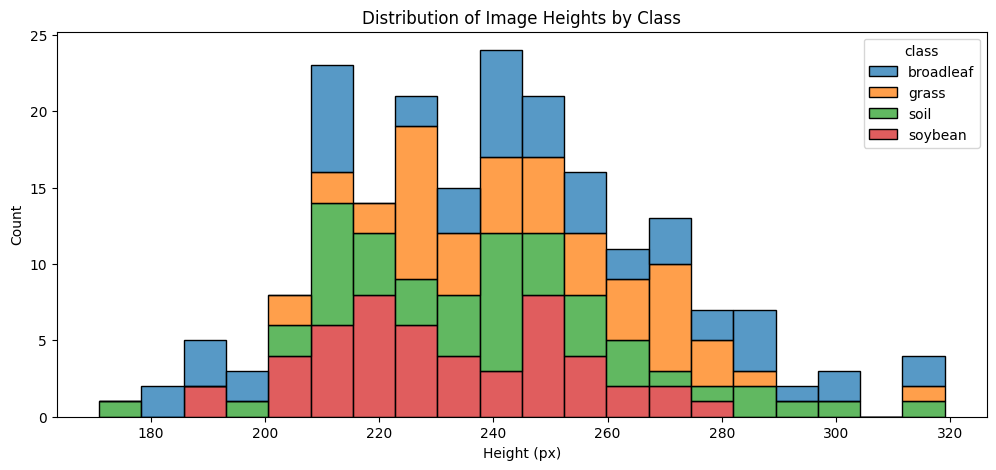

In [4]:
root = Path("C:/Users/16302/.cache/kagglehub/datasets/fpeccia/weed-detection-in-soybean-crops/versions/1")
base = root / "dataset" / "dataset"
base_dir = base

# Define class labels from folder names
classes = sorted(p.name for p in base.iterdir() if p.is_dir())

# Resolution profiling: sample up to 50 images per class and record their sizes
records = []
for cls in classes:
    files = list((base/cls).iterdir())
    sample = random.sample(files, min(50, len(files)))
    for f in sample:
        img = tiff.imread(f)
        records.append({'class': cls, 'height': img.shape[0], 'width': img.shape[1]})
df_shapes = pd.DataFrame(records)

# Univariate Non-Graphical EDA: count images per class
counts = {cls: len(list((base/cls).iterdir())) for cls in classes}
df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['image_count'])
df_counts.index.name = 'class'
print(df_counts)

# Univariate Graphical EDA: Width, Height Distributions
plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='width', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Widths by Class")
plt.xlabel("Width (px)")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(12,5))
sns.histplot(data=df_shapes, x='height', hue='class', multiple='stack', bins=20)
plt.title("Distribution of Image Heights by Class")
plt.xlabel("Height (px)")
plt.ylabel("Count")
plt.show()

Summary Statistics (Height and Width by Class):
          height              width             
             min    mean  max   min    mean  max
class                                           
broadleaf    182  244.82  319   174  242.50  339
grass        202  246.06  315   182  250.48  311
soil         171  239.52  313   197  246.82  351
soybean      190  231.94  277   206  249.04  325


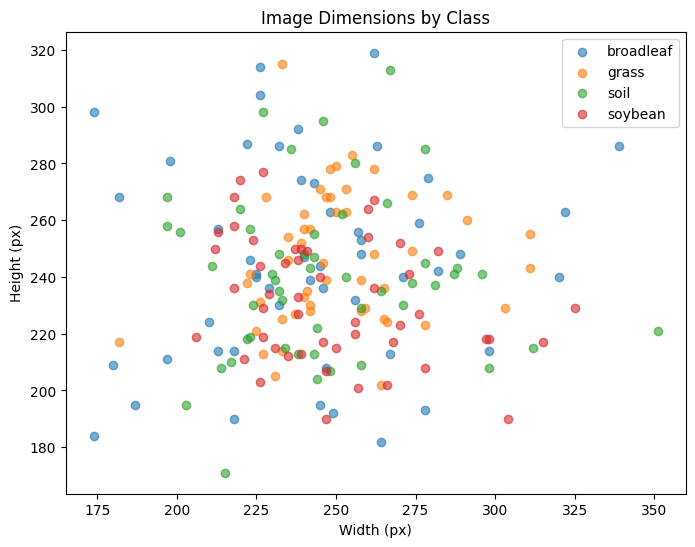

In [5]:
# Multivariate Non-Graphical Summary of Image Dimensions
summary_stats = df_shapes.groupby('class')[['height', 'width']].agg(['min', 'mean', 'max'])
print("Summary Statistics (Height and Width by Class):")
print(summary_stats)

# Multivariate Graphical Analysis - Scatter plot of sampled dimensions
plt.figure(figsize=(8,6))
for cls in classes:
    sub = df_shapes[df_shapes['class']==cls]
    plt.scatter(sub['width'], sub['height'], alpha=0.6, label=cls)
plt.xlabel("Width (px)"); plt.ylabel("Height (px)")
plt.title("Image Dimensions by Class"); plt.legend(); plt.show()

This dataset is imbalanced with soybean having 7,376 samples, while broadleaf, grass, and soil have 1,191, 3,520, and 3,249 images respectively. This will need to be corrected with class weighting or another method. 

Additionally, we have sampled the image dimensions by class and the dimensions range from 158 x 184 px to 404 x 324 px. This may need to be resized to a uniform input size such as 224 x 224 px, for example. 

#### Train Validation Split, Augmentation and class weighting to help with class imbalance


In [6]:
# Image processing config to resize for model input consistency
target_size = (224, 224)
batch_size = 32

In [7]:
# The following code includes data split for 20% validation
# ImageDataGenerator: Handles image preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

# Training generator: Loads training images with augmentations applied
train_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation generator: Loads validation images (no augmentation, just rescaling)
val_gen = datagen.flow_from_directory(
    base_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 12270 images belonging to 4 classes.
Found 3066 images belonging to 4 classes.


The first number is the training set (80%).
The second number is the validation set (20%).

In [8]:
# Get the class labels for each image in the training set
labels = train_gen.classes

# Get mapping from class names to integer indices
class_indices = train_gen.class_indices

# Reverse the mapping to get index → class name
index_to_class = {v: k for k, v in class_indices.items()}

# Compute class weights
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)

# Map weights to class index
class_weights = dict(zip(np.unique(labels), weights))

# Print class index, class name, and class weight
print("Class weights by index and name:")
for idx, weight in class_weights.items():
    class_name = index_to_class[idx]
    print(f"Index {idx}: {class_name:<10} → Weight: {weight:.3f}")

Class weights by index and name:
Index 0: broadleaf  → Weight: 3.219
Index 1: grass      → Weight: 1.089
Index 2: soil       → Weight: 1.180
Index 3: soybean    → Weight: 0.520


The weights are inversely proprtional to class frequency where broadleaf, for example, has the most weight and soybean has the least weight.

## Data Privacy 

Agricultural data does not contain personal identifying patient data or protected health info and data is not from a covered entity (such as hospital, clinical, financial institution); therefore HIPAA or personal protected data is not a concern.

Another possible privacy concern may be with Geolocation Metadata, so checking if any images contain embedded GPS/location metadata can be performed. 
Below, a privacy-related check is performed of the data and cleaning of .tif image files by inspecting them for embedded metadata (EXIF).

In [9]:
# Track whether any metadata was found
found_metadata = False

# Iterate through all .tif files recursively
for img_path in base_dir.rglob("*.tif"):
    try:
        img = Image.open(img_path)
        if "exif" in img.info:
            print(f"Yes metadata: {img_path.name}")
            found_metadata = True
            # Strip metadata by saving a clean copy
            img_no_meta = Image.new(img.mode, img.size)
            img_no_meta.putdata(list(img.getdata()))
            img_no_meta.save(img_path)
    except Exception as e:
        print(f"Error processing {img_path.name}: {e}")

# If no metadata was found in any file
if not found_metadata:
    print("No .tif images with metadata found.")

No .tif images with metadata found.


## Model Evaluation

### CNN (Convolutional Neural Network)

In [10]:
# Define CNN model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),

    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(4, activation='softmax')  # 4 classes
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [11]:
# commented out model training block to avoid re-execution by collaborators

# Train the model with class weights  
# history = model.fit(
#   train_gen,
#   validation_data=val_gen,
#   epochs=10,
#   class_weight=class_weights
# )

#### Load Pretrained Model
To avoid retraining, download the pretrained model from Google Drive and load it:

#### Download pretrained model from Google Drive

Link: [cnn_weed_classifier.keras](https://drive.google.com/file/d/1KOVgouJYtHwyjVX8Ee3f2kAi1Fusaoi0/view?usp=sharing)


In [12]:
# Automatically download the trained model from Google Drive if not already present

# Check if model file exists
if not os.path.exists("cnn_weed_classifier.keras"):
    try:
        # Install gdown if needed
        import gdown
    except ImportError:
        !pip install gdown
        import gdown

    # Download using file ID
    file_id = "1KOVgouJYtHwyjVX8Ee3f2kAi1Fusaoi0"
    gdown.download(id=file_id, output="cnn_weed_classifier.keras", quiet=False)

warnings.filterwarnings("ignore", category=UserWarning, module='keras.src.saving.saving_lib')
# Load the model
model = load_model("cnn_weed_classifier.keras")
print("Model loaded successfully")


Model loaded successfully


This is the original training log output, since this is shared notebook, trained model was saved to avoid re-execution.
To product Epoch results graphically, values are hard coded into the next code.

##### Epoch 1/10   384/384 ━ 701s 2s/step - accuracy: 0.5746 - loss: 0.9424 - val_accuracy: 0.8565 - val_loss: 0.4765

##### Epoch 2/10   384/384 ━ 644s 2s/step - accuracy: 0.8047 - loss: 0.5534 - val_accuracy: 0.8640 - val_loss: 0.3403

##### Epoch 3/10   384/384 ━680s 2s/step - accuracy: 0.8373 - loss: 0.4528 - val_accuracy: 0.8584 - val_loss: 0.3435

##### Epoch 4/10   384/384 ━ 644s 2s/step - accuracy: 0.8512 - loss: 0.4302 - val_accuracy: 0.8405 - val_loss: 0.4844

##### Epoch 5/10   384/384 ━788s 2s/step - accuracy: 0.8688 - loss: 0.3748 - val_accuracy: 0.9260 - val_loss: 0.1976

##### Epoch 6/10   384/384 ━ 719s 2s/step - accuracy: 0.8778 - loss: 0.3783 - val_accuracy: 0.9230 - val_loss: 0.2136

##### Epoch 7/10   384/384 ━ 11114s 29s/step - accuracy: 0.8845 - loss: 0.3505 - val_accuracy: 0.8366 - val_loss: 0.4252

##### Epoch 8/10   384/384 ━ 648s 2s/step - accuracy: 0.8802 - loss: 0.3362 - val_accuracy: 0.8943 - val_loss: 0.2464

##### Epoch 9/10   384/384 ━ 622s 2s/step - accuracy: 0.8985 - loss: 0.2965 - val_accuracy: 0.8891 - val_loss: 0.2969

##### Epoch 10/10   384/384 ━630s 2s/step - accuracy: 0.9112 - loss: 0.2903 - val_accuracy: 0.9367 - val_loss: 0.1712


In [13]:
# Reconstructed training history from earlier run
history = {
    'accuracy': [0.5746, 0.8047, 0.8373, 0.8512, 0.8688, 0.8778, 0.8845, 0.8802, 0.8985, 0.9112],
    'val_accuracy': [0.8565, 0.8640, 0.8584, 0.8405, 0.9260, 0.9230, 0.8366, 0.8943, 0.8891, 0.9367],
    'loss': [0.9424, 0.5534, 0.4528, 0.4302, 0.3748, 0.3783, 0.3505, 0.3362, 0.2965, 0.2903],
    'val_loss': [0.4765, 0.3403, 0.3435, 0.4844, 0.1976, 0.2136, 0.4252, 0.2464, 0.2969, 0.1712]
}

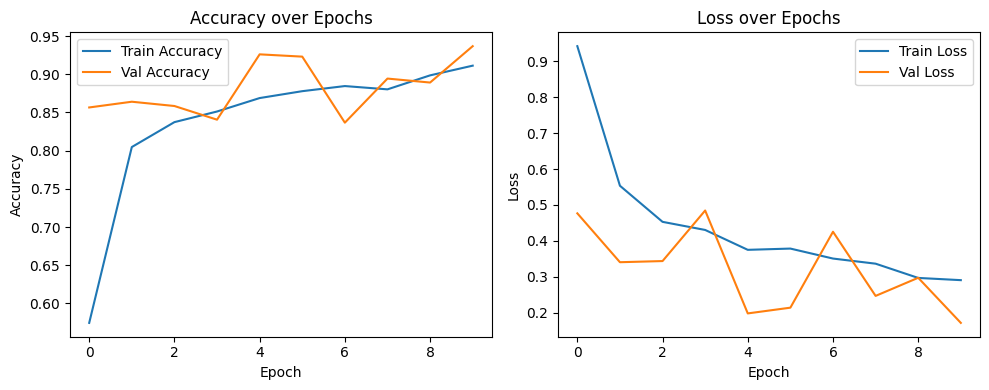

In [14]:
# Plot accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy improved from 57.5% to 91.1%.
Validation Accuracy peaked at 93.7%.
Loss dropped from 94% to 29%.
Validation Loss dropped to 17%.

Plots show there is steady improvement in both training and validation accuracy.
With validation loss decreasing, this indicates model generalizes well.


In [15]:
# Evaluate trained model on validation set
# Get true class labels and predicted labels
y_true = val_gen.classes
y_pred = model.predict(val_gen)  # predicts class probabilities for each validation image
y_pred_labels = np.argmax(y_pred, axis=1) # converts predicted probability scored into class labels by taking index of highest probability in each row

# Print classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_labels, target_names=val_gen.class_indices.keys()))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_labels)
print("Confusion Matrix:\n", cm)

96/96 ━━━━━━━━━━━━━━━━━━━━ 93s 962ms/step
Classification Report:
              precision    recall  f1-score   support

   broadleaf       0.69      0.93      0.79       238
       grass       0.94      0.83      0.88       704
        soil       1.00      1.00      1.00       649
     soybean       0.97      0.97      0.97      1475

    accuracy                           0.94      3066
   macro avg       0.90      0.93      0.91      3066
weighted avg       0.95      0.94      0.94      3066

Confusion Matrix:
 [[ 221    9    0    8]
 [  87  584    0   33]
 [   0    0  649    0]
 [  12   27    0 1436]]


#### CNN Model Summary:
Generalizes well on unseen validation data, high accuracy of 0.94, high F1 scores across most classes means fairly balanced model.
Performed well on Soil class with no misclassifications. Learned Soil features very well.
Broadleaf can be improved. Precision is 0.69, F1 0.79, and Recall 0.93. Model predicts Broadleaf incorrectly/ misclassifies, giving false positives.
